<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/07_pytorch_experiment_tracking.pdf) 

# 07. PyTorch Experiment Tracking

> **Note:** This notebook uses `torchvision`'s new [multi-weight support API (available in `torchvision` v0.13+)](https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/). 



## Different ways to track machine learning experiments 


| **Method** | **Setup** | **Pros** | **Cons** | **Cost** |
| ----- | ----- | ----- | ----- | ----- |
| Python dictionaries, CSV files, print outs | None | Easy to setup, runs in pure Python | Hard to keep track of large numbers of experiments | Free |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/) | Extensions built into PyTorch, widely recognized and used, easily scales. | User-experience not as nice as other options. | Free |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch. | Free for personal use | 
| [MLFlow](https://mlflow.org/) | Minimal, install `mlflow` and start tracking | Fully open-source MLOps lifecycle management, many integrations. | Little bit harder to setup a remote tracking server than other services. | Free | 



## What we're going to cover

This notebook focuses on using TensorBoard to track our experiments.
However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Getting setup** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **1. Get data** | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our FoodVision Mini model's results. |
| **2. Create Datasets and DataLoaders** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **3. Get and customise a pretrained model** | Just like the last section, 06. PyTorch Transfer Learning we'll download a pretrained model from `torchvision.models` and customise it to our own problem. | 
| **4. Train model and track results** | Let's see what it's like to train and track the training results of a single model using TensorBoard. |
| **5. View our model's results in TensorBoard** | Previously we visualized our model's loss curves with a helper function, now let's see what they look like in TensorBoard. |
| **6. Creating a helper function to track experiments** | If we're going to be adhering to the machine learner practitioner's motto of *experiment, experiment, experiment!*, we best create a function that will help us save our modelling experiment results. |
| **7. Setting up a series of modelling experiments** | Instead of running experiments one by one, how about we write some code to run several experiments at once, with different models, different amounts of data and different training times. | 
| **8. View modelling experiments in TensorBoard** | By this stage we'll have run eight modelling experiments in one go, a fair bit to keep track of, let's see what their results look like in TensorBoard. | 
| **9. Load in the best model and make predictions with it** | The point of experiment tracking is to figure out which model performs the best, let's load in the best performing model and make some predictions with it to *visualize, visualize, visualize!*. |

## Where can you get help?

All of the materials for this course [are available on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## 0. Getting setup 

We're going to download the [`going_modular`](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular) directory from the `pytorch-deep-learning` repository (if we don't already have it).

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available. 

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.8.0+cu128
torchvision version: 0.23.0+cu128


> **Note:** If you're using Google Colab, you may have to restart your runtime after running the above cell. After restarting, you can run the cell again and verify you've got the right versions of `torch` (0.12+) and `torchvision` (0.13+).

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create a helper function to set seeds



In [5]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get data



In [6]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

Create a transform to prepare our images correctly.

To transform our images into tensors, we can use:
1. Manually created transforms using `torchvision.transforms`.
2. Automatically created transforms using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms()`.
    * Where `MODEL_NAME` is a specific `torchvision.models` architecture, `MODEL_WEIGHTS` is a specific set of pretrained weights and `DEFAULT` means the "best available weights".
    
Let's see first an example of manually creating a `torchvision.transforms` pipeline (creating a transforms pipeline this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained `torchvision.models` are all pretrained on [ImageNet](https://www.image-net.org/)).

We can do this with:

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

### 2.1 Create DataLoaders using manually created transforms

In [7]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7a0466bea690>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms



In [8]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7a0466afa480>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

Let's download the pretrained weights for a `torchvision.models.efficientnet_b0()` model and prepare it for use with our own data.

In [9]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model


Now we've got a pretrained model let's turn it into a feature extractor model.
In essence, we'll freeze the base layers of the model (we'll use these to extract features from our input images) and we'll change the classifier head (output layer) to suit the number of classes we're working with (we've got 3 classes: pizza, steak, sushi).


In [11]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [12]:
from torchinfo import summary

# Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-output-of-torchinfo-summary.png" alt="output of torchinfo.summary() when passed our model when base layers are frozen and classifier head is updated" width=900/>

*Output of `torchinfo.summary()` with our feature extractor EffNetB0 model, notice how the base layers are frozen (not trainable) and the output layers are customized to our own problem.*

## 4. Train model and track results

Let's get ready to train by creating a loss function and an optimizer.


In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Adjust `train()` function to track results with `SummaryWriter()`

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter. 
The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.
But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).
The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).
TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default `SummaryWriter()` instance.

In [14]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

[INFO] Couldn't find tensorboard... installing it.


Now to use the writer could adjust the existing `train()` function we created in [05. PyTorch Going Modular section 4](https://www.learnpytorch.io/05_pytorch_going_modular/#4-creating-train_step-and-test_step-functions-and-train-to-combine-them).

We'll get the `train()` function from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) and adjust it to use `writer`.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with [`writer.add_scalars(main_tag, tag_scalar_dict)`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars), where:
* `main_tag` (string) - the name for the scalars being tracked (e.g. "Accuracy")
* `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g. `{"train_loss": 0.3454}`)
    > **Note:** The method is called `add_scalars()` because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

To start modifying `train()` we'll also import `train_step()` and `test_step()` from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py).

> **Note:** You can track information about your model almost anywhere in your code. But quite often experiments will be tracked *while* a model is training (inside a training/testing loop).
>
> The `torch.utils.tensorboard.SummaryWriter()` class also has many different methods to track different things about your model/data, such as [`add_graph()`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph) which tracks the computation graph of your model. For more options, [check the `SummaryWriter()` documentation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter).

In [15]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.engine import train_step, test_step


# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [16]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909
Epoch: 2 | train_loss: 0.9047 | train_acc: 0.6445 | test_loss: 0.7883 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.8096 | train_acc: 0.7344 | test_loss: 0.6768 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6849 | train_acc: 0.8594 | test_loss: 0.6738 | test_acc: 0.8049
Epoch: 5 | train_loss: 0.7080 | train_acc: 0.7266 | test_loss: 0.6793 | test_acc: 0.7737



Running the cell above we get similar outputs we got in [06. PyTorch Transfer Learning section 4: Train model](https://www.learnpytorch.io/06_pytorch_transfer_learning/#4-train-model) but the difference is that behind the scenes our `writer` instance has created a `runs/` directory storing our model's results. Where the [default format](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter) is `runs/CURRENT_DATETIME_HOSTNAME`. 

We'll check these out in a second but just as a reminder, we were previously tracking our model's results in a dictionary.

In [17]:
# Check out the model results
results

{'train_loss': [1.0961893498897552,
  0.9046788439154625,
  0.8095746487379074,
  0.6849066615104675,
  0.7080409228801727],
 'train_acc': [0.390625, 0.64453125, 0.734375, 0.859375, 0.7265625],
 'test_loss': [0.9143912394841512,
  0.7882673541704813,
  0.6768001119295756,
  0.6738391915957133,
  0.6792910893758138],
 'test_acc': [0.5909090909090909,
  0.8257575757575758,
  0.8863636363636364,
  0.8049242424242425,
  0.7736742424242425]}

Hmmm, we could format this to be a nice plot but could you imagine keeping track of a bunch of these dictionaries?

There has to be a better way...

## 5. View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default.

You can view TensorBoard in a number of ways:

| Code environment | How to view TensorBoard | Resource |
| ----- | ----- | ----- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard". | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration) |
| Jupyter and Colab Notebooks | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.

```python
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

In [19]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6007 (pid 40210), started 0:01:33 ago. (Use '!kill 40210' to kill it.)

## 6. Create a helper function to build `SummaryWriter()` instances

The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter.

How about we make a helper function to create a custom directory per experiment?
In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:
* **Experiment date/timestamp** - when did the experiment take place?
* **Experiment name** - is there something we'd like to call the experiment?
* **Model name** - what model was used?
* **Extra** - should anything else be tracked?

Let's create a helper function called `create_writer()` that produces a `SummaryWriter()` instance tracking to a custom `log_dir`.

Ideally, we'd like the `log_dir` to be something like: 

`runs/YYYY-MM-DD/experiment_name/model_name/extra` 


In [21]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [22]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2025-10-09/data_10_percent/effnetb0/5_epochs...


### 6.1 Update the `train()` function to include a `writer` parameter

Let's give our `train()` function the ability to take in a `writer` parameter so we actively update the `SummaryWriter()` instance we're using each time we call `train()`.
One `writer` per experiment = one logs directory per experiment.

To adjust the `train()` function we'll add a `writer` parameter to the function and then we'll add some code to see if there's a `writer` and if so, we'll track our information there.

In [23]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments


### 7.1 What kind of experiments should you run?

Every hyperparameter stands as a starting point for a different experiment: 
* Change the number of **epochs**.
* Change the number of **layers/hidden units**.
* Change the amount of **data**.
* Change the **learning rate**.
* Try different kinds of **data augmentation**.
* Choose a different **model architecture**. 



### 7.2 What experiments are we going to run?

Let's try a combination of:
1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model ([`torchvision.models.efficientnet_b0`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) vs. [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2))
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get: 

| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| ----- | ----- | ----- | ----- |
| 1 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 | 
| 3 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 | 
| 4 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |

Notice how we're slowly scaling things up. 

With each experiment we slowly increase the amount of data, the model size and the length of training.

By the end, experiment 8 will be using double the data, double the model size and double the length of training compared to experiment 1.

> **Note:** I want to be clear that there truly is no limit to amount of experiments you can run. What we've designed here is only a very small subset of options. However, you can't test *everything* so best to try a few things to begin with and then follow the ones which work the best.
>
> And as a reminder, the datasets we're using are a subset of the [Food101 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101) (3 classes, pizza, steak, suhsi, instead of 101) and 10% and 20% of the images rather than 100%. If our experiments work, we could start to run more on more data (though this will take longer to compute). You can see how the datasets were created via the [`04_custom_data_creation.ipynb` notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb). 


### 7.3 Download different datasets

We'll need two forms of a training set:
1. A training set with **10% of the data** of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
2. A training set with **20% of the data** of Food101 pizza, steak, sushi images.

For consistency, all experiments will use the same testing dataset (the one from the 10% data split).

Both datasets are available from the course GitHub:
1. [Pizza, steak, sushi 10% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip).
2. [Pizza, steak, sushi 20% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip). 

In [24]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...



We'll create different training directory paths but we'll only need one testing directory path since all experiments will be using the same test dataset (the test dataset from pizza, steak, sushi 10%).

In [25]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create DataLoaders

Next we'll create a series of transforms to prepare our images for our model(s).

To keep things consistent, we'll *manually* create a *transform* and use the same transform across all of the datasets.

The transform will: 
1. Resize all the images (we'll start with 224, 224 but this could be changed).
2. Turn them into tensors with values between 0 & 1. 
3. Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) have been pretrained on ImageNet).

In [26]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

Now let's create our DataLoaders using the `create_dataloaders()` function from `data_setup.py` we created in [05. PyTorch Going Modular section 2](https://www.learnpytorch.io/05_pytorch_going_modular/#2-create-datasets-and-dataloaders-data_setuppy). 

For all of our experiments we'll be using the same `test_dataloader` (to keep comparisons consistent).

In [27]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We're going to create two feature extractor models: 

1. [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html) pretrained backbone + custom classifier head (EffNetB0 for short).
2. [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) pretrained backbone + custom classifier head (EffNetB2 for short).

To do this, we'll freeze the base layers (the feature layers) and update the model's classifier heads (output layers) to suit our problem just like we did in [06. PyTorch Transfer Learning section 3.4](https://www.learnpytorch.io/06_pytorch_transfer_learning/#34-freezing-the-base-model-and-changing-the-output-layer-to-suit-our-needs).

The `in_features` parameter to the classifier head of EffNetB0 is `1280` (the backbone turns the input image into a feature vector of size `1280`). Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

> **Note:** Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using [`torchinfo.summary()`](https://github.com/TylerYep/torchinfo) and passing in the `input_size=(32, 3, 224, 224)` parameter (`(32, 3, 224, 224)` is equivalent to `(batch_size, color_channels, height, width)`, i.e we pass in an example of what a single batch of data would be to our model).

> **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) layer, this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `torchinfo.summary()` or to your own models using the layer.

To find the required input shape to the final layer of EffNetB2, let's:
1. Create an instance of `torchvision.models.efficientnet_b2(pretrained=True)`.
2. See the various input and output shapes by running `torchinfo.summary()`.
3. Print out the number of `in_features` by inspecting `state_dict()` of the classifier portion of EffNetB2 and printing the length of the weight matrix.
    > **Note:** You could also just inspect the output of `effnetb2.classifier`.


In [31]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 
# 3. Get the number of in_features of the EfficientNetB2 classifier layer
# print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb2-unfrozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb2 model with all layers trainable and default classifier head" width=900/>

*Model summary of EffNetB2 feature extractor model with all layers unfrozen (trainable) and default classifier head from ImageNet pretraining.*

Now we know the required number of `in_features` for the EffNetB2 model, let's create a couple of helper functions to setup our EffNetB0 and EffNetB2 feature extractor models.

We want these functions to:
1. Get the base model from `torchvision.models`
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds (we don't *need* to do this but since we're running a series of experiments and initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
4. Change the classifier head (to suit our problem)
5. Give the model a name (e.g. "effnetb0" for EffNetB0)

In [32]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [33]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb0 model.


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb0-frozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb0 model with base layers are frozen and classifier head is updated" width=900/>

*Model summary of EffNetB0 model with base layers frozen (untrainable) and updated classifier head (suited for pizza, steak, sushi image classification).*

In [34]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb2 model.


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb2-frozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb2 model with base layers are frozen and classifier head is updated" width=900/>

*Model summary of EffNetB2 model with base layers frozen (untrainable) and updated classifier head (suited for pizza, steak, sushi image classification).*

Looking at the outputs of the summaries, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

| Model | Total parameters (before freezing/changing head) | Total parameters (after freezing/changing head) | Total trainable parameters (after freezing/changing head) |
| ----- | ----- | ----- | ----- |
| EfficientNetB0 | 5,288,548 | 4,011,391 | 3,843 |  
| EfficientNetB2 | 9,109,994 | 7,705,221 | 4,227 |



### 7.6 Create experiments and set up training code

We've prepared our data and prepared our models, the time has come to setup some experiments!

We'll start by creating two lists and a dictionary:
1. A list of the number of epochs we'd like to test (`[5, 10]`)
2. A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
3. A dictionary of the different training DataLoaders

In [35]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

Lists and dictionary created!

Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps: 
1. Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
2. Keep track of different experiment numbers (this is mostly for pretty print outs).
3. Loop through the `train_dataloaders` dictionary items for each of the different training DataLoaders.
4. Loop through the list of epoch numbers.
5. Loop through the list of different model names.
6. Create information print outs for the current running experiment (so we know what's happening).
7. Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
8. Create a new loss function (`torch.nn.CrossEntropyLoss()`) and optimizer (`torch.optim.Adam(params=model.parameters(), lr=0.001)`) for each new experiment.
9. Train the model with the modified `train()` function passing the appropriate details to the `writer` parameter.
10. Save the trained model with an appropriate file name to file with `save_model()` from [`utils.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/utils.py). 

We can also use the `%%time` magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

Let's do it!

In [37]:
%%time
from going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-10-09/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8100 | train_acc: 0.6445 | test_loss: 0.7175 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5981 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-10-09/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7192 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-10-09/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0528 | train_acc: 0.4961 | test_loss: 0.9217 | test_acc: 0.4678
Epoch: 2 | train_loss: 0.8747 | train_acc: 0.6992 | test_loss: 0.8138 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8100 | train_acc: 0.6445 | test_loss: 0.7175 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7098 | train_acc: 0.7578 | test_loss: 0.5898 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5981 | train_acc: 0.9141 | test_loss: 0.5676 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5612 | train_acc: 0.8984 | test_loss: 0.5949 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5574 | train_acc: 0.7930 | test_loss: 0.5567 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4703 | train_acc: 0.9492 | test_loss: 0.5177 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7773 | test_loss: 0.5095 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4795 | train_acc: 0.8242 | test_loss: 0.4640 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3711 | test_loss: 0.9557 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9248 | train_acc: 0.6445 | test_loss: 0.8711 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8086 | train_acc: 0.7656 | test_loss: 0.7511 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.7192 | train_acc: 0.8867 | test_loss: 0.7149 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6850 | train_acc: 0.7695 | test_loss: 0.7076 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6111 | train_acc: 0.7812 | test_loss: 0.6325 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6127 | train_acc: 0.8008 | test_loss: 0.6403 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5202 | train_acc: 0.9336 | test_loss: 0.6199 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5426 | train_acc: 0.8008 | test_loss: 0.6226 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4909 | train_acc: 0.8125 | test_loss: 0.5871 | test_acc: 0.8873
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4459 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3909 | test_acc: 0.9176
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2025-10-09/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7768 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2025-10-09/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9576 | train_acc: 0.6188 | test_loss: 0.6545 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6881 | train_acc: 0.8438 | test_loss: 0.5799 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5798 | train_acc: 0.8625 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4930 | train_acc: 0.8646 | test_loss: 0.4459 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3909 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3705 | train_acc: 0.8854 | test_loss: 0.3568 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3551 | train_acc: 0.9250 | test_loss: 0.3186 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3745 | train_acc: 0.8938 | test_loss: 0.3350 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.2972 | train_acc: 0.9396 | test_loss: 0.3093 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3620 | train_acc: 0.8479 | test_loss: 0.2780 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9830 | train_acc: 0.5542 | test_loss: 0.7768 | test_acc: 0.8153
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.7604 | test_loss: 0.6673 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6022 | train_acc: 0.8458 | test_loss: 0.5622 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5436 | train_acc: 0.8354 | test_loss: 0.5678 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.4404 | train_acc: 0.9042 | test_loss: 0.4461 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3889 | train_acc: 0.9104 | test_loss: 0.4554 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3483 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8771 | test_loss: 0.4344 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3308 | train_acc: 0.8979 | test_loss: 0.4241 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3383 | train_acc: 0.8896 | test_loss: 0.3906 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in TensorBoard



In [38]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 40210), started 0:36:03 ago. (Use '!kill 40210' to kill it.)

Running the cell above we should get an output similar to the following.

> **Note:** Depending on the random seeds you used/hardware you used there's a chance your numbers aren't exactly the same as what's here. This is okay. It's due to the inherent randomness of deep learning. What matters most is the trend. Where your numbers are heading. If they're off by a large amount, perhaps there's something wrong and best to go back and check the code. But if they're off by a small amount (say a couple of decimal places or so), that's okay. 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-tensorboard-lowest-test-loss.png" alt="various modelling experiments visualized on tensorboard with model that has the lowest test loss highlighted" width=900/>

*Visualizing the test loss values for the different modelling experiments in TensorBoard, you can see that the EffNetB0 model trained for 10 epochs and with 20% of the data achieves the lowest loss. This sticks with the overall trend of the experiments that: more data, larger model and longer training time is generally better.*

## 9. Load in the best model and make predictions with it

Experiment number 8 achieved the best overall results (highest test accuracy, second lowest test loss).

* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 10 epochs (double the original training time)

Experiment number 6 achieved similar results in half the training time.
This suggests that potentially the most influential parts of our experiments were the number of parameters and the amount of data.

Inspecting the results further it seems that generally a model with more parameters (EffNetB2) and more data (20% pizza, steak, sushi training data) performs better (lower test loss and higher test accuracy).

We can import the best saved model by creating a new instance of EffNetB2 using the `create_effnetb2()` function and then load in the saved `state_dict()` with `torch.load()`.

In [39]:
# Setup the best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [56]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB



We created a `pred_and_plot_image()` function to use a trained model to make predictions on an image in [06. PyTorch Transfer Learning section 6](https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set).
And we can reuse this function by importing it from [`going_modular.predictions.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/predictions.py).

So to make predictions on various images the model hasn't seen before, we'll first get a list of all the image filepaths from the 20% pizza, steak, sushi testing dataset and then we'll randomly select a subset of these filepaths to pass to our `pred_and_plot_image()` function.

In [2]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
import torch
import torchvision
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt


num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

NameError: name 'torch' is not defined

Nice!

Running the cell above a few times we can see our model performs quite well and often has higher prediction probabilities than previous models we've built.

This suggests the model is more confident in the decisions it's making. 

### 9.1 Predict on a custom image with the best model

Making predictions on the test dataset is cool but the real magic of machine learning is making predictions on custom images of your own.

So let's import the trusty [pizza dad image](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) (a photo of my dad in front of a pizza) we've been using for the past couple of sections and see how our model performs on it.

data/04-pizza-dad.jpeg already exists, skipping download.


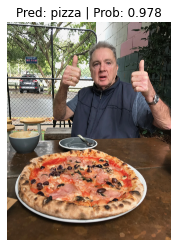

In [35]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Woah!

Two thumbs again!

Our best model predicts "pizza" correctly and this time with an even higher prediction probability (0.978) than the first feature extraction model we trained and used in [06. PyTorch Transfer Learning section 6.1](https://www.learnpytorch.io/06_pytorch_transfer_learning/#61-making-predictions-on-a-custom-image).

This again suggests our current best model (EffNetB2 feature extractor trained on 20% of the pizza, steak, sushi training data and for 10 epochs) has learned patterns to make it more confident of its decision to predict pizza.

I wonder what could improve our model's performance even further? 

I'll leave that as a challenge for you to investigate.

## Main takeaways

We've now gone full circle on the PyTorch workflow introduced in [01. PyTorch Workflow Fundamentals](https://www.learnpytorch.io/01_pytorch_workflow/), we've gotten data ready, we've built and picked a pretrained model, we've used our various helper functions to train and evaluate the model and in this notebook we've improved our FoodVision Mini model by running and tracking a series of experiments.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

You should be proud of yourself, this is no small feat!

The main ideas you should take away from this Milestone Project 1 are:

* The machine learning practitioner's motto: *experiment, experiment, experiment!* (though we've been doing plenty of this already).
* In the beginning, keep your experiments small so you can work fast, your first few experiments shouldn't take more than a few seconds to a few minutes to run.
* The more experiments you do, the quicker you can figure out what *doesn't* work.
* Scale up when you find something that works. For example, since we've found a pretty good performing model with EffNetB2 as a feature extractor, perhaps you'd now like to see what happens when you scale it up to the whole [Food101 dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) from `torchvision.datasets`.
* Programmatically tracking your experiments takes a few steps to set up but it's worth it in the long run so you can figure out what works and what doesn't.
    * There are many different machine learning experiment trackers out there so explore a few and try them out.

## Exercises

> **Note:** These exercises expect the use of `torchvision` v0.13+ (released July 2022), previous versions may work but will likely have errors.

All of the exercises are focused on practicing the code above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 07](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/07_pytorch_experiment_tracking_exercise_template.ipynb)
* [Example solutions notebook for 07](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/07_pytorch_experiment_tracking_exercise_solutions.ipynb) (try the exercises *before* looking at this)
    * See a live [video walkthrough of the solutions on YouTube](https://youtu.be/cO_r2FYcAjU) (errors and all)


1. Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher). 
    * How does it perform compared to our existing models?
2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    * For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
    * **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Helper function to view images in a DataLoader (works with data augmentation transforms or not) 
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# different train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    * You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
    * If you try more than one model, it would be good to have the model's results tracked.
    * If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
    * **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

## Extra-curriculum

* Read [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) blog post by Richard Sutton to get an idea of how many of the latest advancements in AI have come from increased scale (bigger datasets and bigger models) and more general (less meticulously crafted) methods.
* Go through the [PyTorch YouTube/code tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) for TensorBoard for 20-minutes and see how it compares to the code we've written in this notebook.
* Perhaps you may want to view and rearrange your model's TensorBoard logs with a DataFrame (so you can sort the results by lowest loss or highest accuracy), there's a guide for this [in the TensorBoard documentation](https://www.tensorflow.org/tensorboard/dataframe_api). 
* If you like to use VSCode for development using scripts or notebooks (VSCode can now use Jupyter Notebooks natively), you can setup TensorBoard right within VSCode using the  [PyTorch Development in VSCode guide](https://code.visualstudio.com/docs/datascience/pytorch-support).
* To go further with experiment tracking and see how your PyTorch model is performing from a speed perspective (are there any bottlenecks that could be improved to speed up training?), see the [PyTorch documentation for the PyTorch profiler](https://pytorch.org/blog/introducing-pytorch-profiler-the-new-and-improved-performance-tool/).
* Made With ML is an outstanding resource for all things machine learning by Goku Mohandas and their [guide on experiment tracking](https://madewithml.com/courses/mlops/experiment-tracking/) contains a fantastic introduction to tracking machine learning experiments with MLflow.